library

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM

dataframe

In [2]:
df =  pd.read_csv('Avocado.csv')
df = df[['Date', 'AveragePrice']]
df.tail()

,Date,AveragePrice
27318,2015-11-22,1.97
27319,2015-11-29,2.08
27320,2015-12-13,1.80
27321,2015-12-20,1.92
27322,2015-12-27,1.81


data preprocessing

In [3]:
date = df['Date'].values
price = df['AveragePrice'].values

In [4]:
sum_train = int(len(date)*0.8)
sum_valid = int(len(date)*0.2)

date_train = date[0:sum_train]
date_valid = date[sum_train:len(date)]
price_train = price[0:sum_train]
price_valid = price[sum_train:len(date)]

print("Training data: ", len(date_train), ',', len(price_train))
print("Validation data: ", len(date_valid), ',', len(price_valid))

Training data:  21858 , 21858
Validation data:  5465 , 5465


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size +1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

model

In [20]:
train_set = windowed_dataset(price_train, window_size=60, batch_size=100, shuffle_buffer=1000)
valid_set = windowed_dataset(price_valid, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60),
                                    tf.keras.layers.Dense(8, activation="relu"),
                                    tf.keras.layers.Dropout(0.5), 
                                    tf.keras.layers.Dense(1),
])

optimizer and loss function

In [21]:
optimizer = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

callbacks

In [22]:
class callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    #Nilai mae sebenarnya 0.281 namun pada callback diturunkan
    if(logs.get('mae') is not None and logs.get('mae') <= 0.278 and logs.get('val_mae') <= 0.278): 
      self.model.stop_training = True

callbacks = callback()

training model

In [23]:
history = model.fit(train_set, epochs=100, callbacks=[callbacks],
                    validation_data=(valid_set), verbose=2)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

218/218 - 4s - loss: 0.0558 - mae: 0.2538 - val_loss: 0.0671 - val_mae: 0.2781
Epoch 2/100
218/218 - 4s - loss: 0.0481 - mae: 0.2413 - val_loss: 0.0667 - val_mae: 0.2787
Epoch 3/100
218/218 - 5s - loss: 0.0485 - mae: 0.2426 - val_loss: 0.0669 - val_mae: 0.2784
Epoch 4/100
218/218 - 4s - loss: 0.0480 - mae: 0.2414 - val_loss: 0.0664 - val_mae: 0.2812
Epoch 5/100
218/218 - 4s - loss: 0.0483 - mae: 0.2419 - val_loss: 0.0669 - val_mae: 0.2784
Epoch 6/100
218/218 - 4s - loss: 0.0483 - mae: 0.2421

mae plot

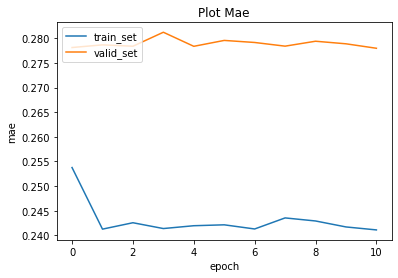

In [24]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Plot Mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train_set', 'valid_set'], loc='upper left')
plt.show()

loss plot

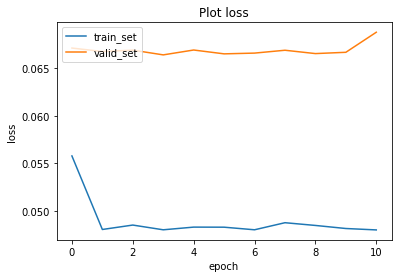

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Plot loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_set', 'valid_set'], loc='upper left')
plt.show()